In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense,Input,Dropout,Flatten,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [12]:
path = '../input/face-expression-recognition-dataset/images/'

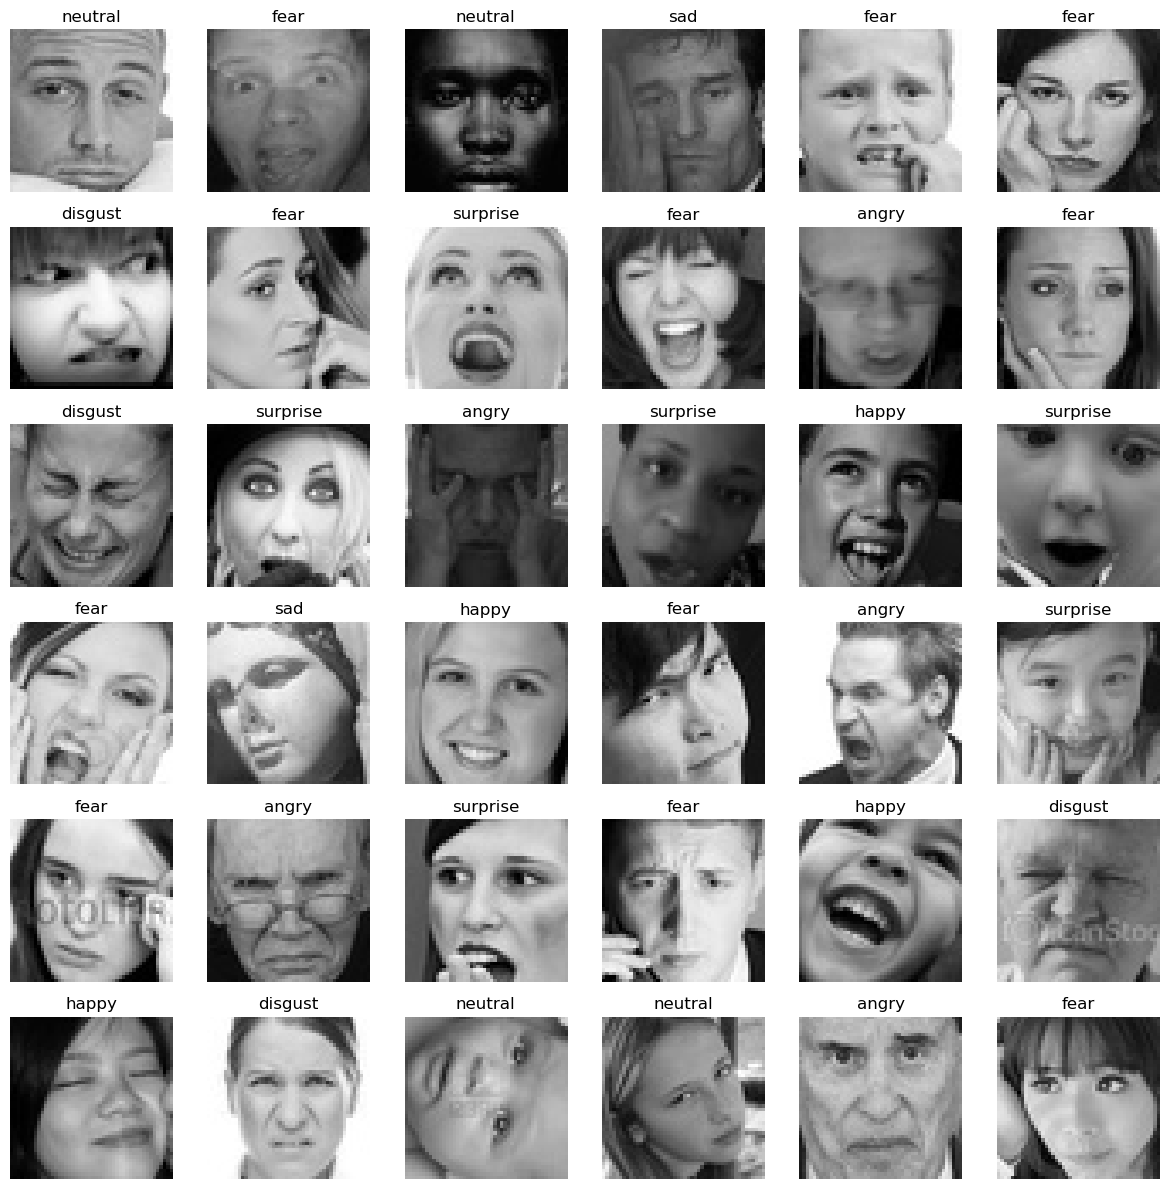

In [14]:
import random
expressions = ['angry', 'sad', 'happy', 'disgust', 'fear', 'neutral', 'surprise']
random.shuffle(expressions)
plt.figure(figsize=(12, 12))
index = 1

for i in range(1,37):
    expression = random.choice(expressions)
    image_path = os.path.join(path, 'train', expression)
    image_files = os.listdir(image_path)
    random.shuffle(image_files)
    image = load_img(os.path.join(image_path, image_files[i]), target_size=(48, 48))
    plt.subplot(6, 6, index)
    plt.imshow(image)
    plt.title(expression)
    plt.axis('off')
    index += 1

plt.tight_layout()
plt.show()

In [15]:
batch_size = 128
train_datagenerator = ImageDataGenerator()
validation_datagenerator = ImageDataGenerator()

train_set = train_datagenerator.flow_from_directory(path+'train',
                                                   target_size=(48, 48), 
                                                   color_mode="grayscale",
                                                   class_mode="categorical", 
                                                   batch_size=batch_size, 
                                                   shuffle=True)
test_set = validation_datagenerator.flow_from_directory(path+'validation',
                                                       target_size=(48, 48), 
                                                       color_mode="grayscale",
                                                       class_mode="categorical", 
                                                       batch_size=batch_size, 
                                                       shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [18]:
classes = 7
model = Sequential()

#1st CNN layer
model.add(Conv2D(64, (3,3), padding="same", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, (5,5), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#1st connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
          
#2nd connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
          
model.add(Dense(classes, activation='softmax'))
          
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

In [21]:
model_checkpoint = ModelCheckpoint("./model.h5", 
                                   monitor="val_acc", 
                                   verbose=1, 
                                   save_best_only=True, 
                                   mode="max")

early_stop = EarlyStopping(monitor="val_loss",
                           min_delta=0,
                           patience=3,
                           verbose=1,
                           restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", 
                                         factor=0.2, 
                                         patience=3, 
                                         verbose=1,
                                         min_delta=0.0001)

callbacks_list = [early_stop, model_checkpoint, reduce_learning_rate]
epochs = 48

In [22]:
history = model.fit(train_set, 
                    epochs=epochs, 
                    callbacks=callbacks_list, 
                    validation_data=test_set,
                    steps_per_epoch=train_set.n//train_set.batch_size, 
                    validation_steps=test_set.n//test_set.batch_size)

model.save("./emotion_detection_model.h5")

Epoch 1/48
225/225 [==============================] - 51s 226ms/step - loss: 1.5754 - accuracy: 0.3947 - val_loss: 1.5470 - val_accuracy: 0.4182 - lr: 1.0000e-04
Epoch 2/48
225/225 [==============================] - 52s 231ms/step - loss: 1.5295 - accuracy: 0.4143 - val_loss: 1.4447 - val_accuracy: 0.4412 - lr: 1.0000e-04
Epoch 3/48
225/225 [==============================] - 53s 236ms/step - loss: 1.4743 - accuracy: 0.4324 - val_loss: 1.3925 - val_accuracy: 0.4599 - lr: 1.0000e-04
Epoch 4/48
225/225 [==============================] - 52s 230ms/step - loss: 1.4233 - accuracy: 0.4519 - val_loss: 1.3648 - val_accuracy: 0.4726 - lr: 1.0000e-04
Epoch 5/48
225/225 [==============================] - 52s 232ms/step - loss: 1.3896 - accuracy: 0.4671 - val_loss: 1.4618 - val_accuracy: 0.4624 - lr: 1.0000e-04
Epoch 6/48
225/225 [==============================] - 52s 230ms/step - loss: 1.3551 - accuracy: 0.4798 - val_loss: 1.2987 - val_accuracy: 0.5102 - lr: 1.0000e-04
Epoch 7/48
225/225 [========

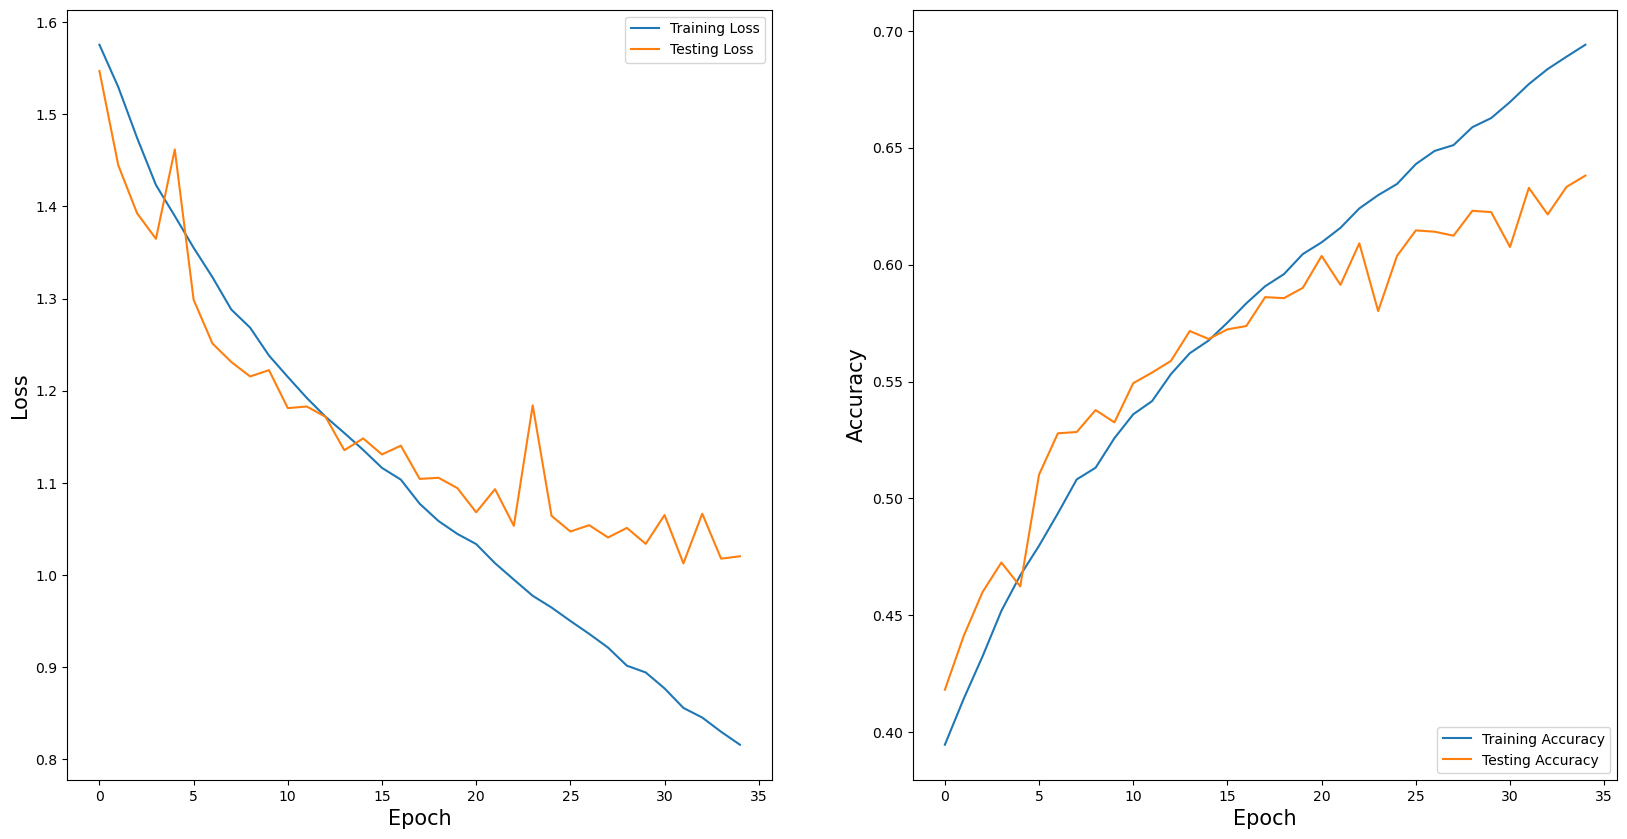

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.legend(loc='lower right')
plt.show()